## run this cell before starting spark cluster connection (corrects module error)

In [1]:
import os
print os.environ['PYSPARK_PYTHON']
os.environ['PYSPARK_PYTHON']=os.environ['LCG_VIEW'] + '/bin/python'
print os.environ['PYSPARK_PYTHON']

/etc/spark/python
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/bin/python


### Import necessary spark and python stuff

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 500)

### select the data
*path_on_hdfs_to_your_data*

In [4]:
df = spark.read.json("/user/rucio01/traces/traces.2018-04*")
#df2 = spark.read.json("/user/rucio01/traces/traces.2018-02*")
#df3 = spark.read.json("/user/rucio01/traces/traces.2018-03*")

In [5]:
#df = df1.union(df2.union(df3))
#df.head()

Row(account=u'pilot', appid=None, catStart=None, clientState=u'DONE', dataset=u'', datasetName=None, datasetScope=u'', dataset_scope=None, duid=None, eventType=u'download', eventVersion=u'1.14.11', filename=u'EventService_premerge_3886111819_13607623-3886111819-13041798597-3795-10.tar', filesize=None, guid=None, hostname=u'b6ac037cc1.cern.ch', ip=None, localSite=None, name=None, pq=None, protocol=u's3', relativeStart=None, remoteSite=u'CERN-PROD_ES', scope=u'transient', stateReason=None, suspicious=None, taskid=None, timeEnd=None, timeStart=None, traceId=u'e68c1b1bbee84d5a96dcfc2f38dc26bb', traceIp=u'::ffff:188.184.146.18', traceTimeentry=u'2018-03-31T22:00:00.005599', traceTimeentryUnix=1522533600.005599, transferEnd=1522533599.975359, transferStart=1522533588.042424, url=None, usr=None, usrdn=None, uuid=u'53cf181ec38b4e2a8885b2a81109d505', validateStart=None, version=None)

### Create temporary table view

In [6]:
# body_schema = spark.read.json(df_loadAvg.rdd.map(lambda row: row.body)).schema
df.createOrReplaceTempView("traces")

### Use PySpark to query download events and split dataset DID into new features

In [7]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [8]:
df_ps = spark.sql("SELECT *\
                    FROM traces \
                    WHERE eventType=='download' AND clientState != 'ALREADY_DONE' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')")\

In [9]:
df_ps.describe().toPandas()

summary  account appid catStart         clientState  \
0  count   790748   0     0        790748               
1  mean    None     None  None     None                 
2  stddev  None     None  None     None                 
3  min     aagaard  None  None     CannotAuthenticate   
4  max     zzheng   None  None     SourceNotFound       

                                                                                               dataset  \
0  790748                                                                                                
1  None                                                                                                  
2  None                                                                                                  
3  data10_hi.00169927.physics_bulk.ROOT.NTUP_HI.r2111_p456                                               
4  mc16_valid.423105.Pythia8EvtGen_A14NNPDF23LO_gammajet_DP280_500.merge.AOD.e5094_s3238_r10441_r10210   

  datasetName datasetScope dataset_scope  duid eventType        eventVersion  \
0  0           790748       0             0     790748    790748               
1  None        None         None          None  None      None                 
2  None        None         None          None  None      None                 
3  None        data10_hi    None          None  download  1.13.2               
4  None        mc16_valid   None          None  download  webui_1.15.3.post1   

                             filename              filesize  guid  \
0  781932                              790748                0      
1  None                                6.074313714038163E8   None   
2  None                                1.2342018230257442E9  None   
3  AOD.05371635._000001.pool.root.1    10000                 None   
4  log.13787275._000072.job.log.tgz.1  999995790             None   

                   hostname    ip localSite  \
0  790746                    0     0          
1  None                      None  None       
2  None                      None  None       
3  ReCaS-ui-01.cs.infn.it    None  None       
4  xenia.nevis.columbia.edu  None  None       

                                       name    pq protocol relativeStart  \
0  8816                                      0     790748   0              
1  None                                      None  None     None           
2  None                                      None  None     None           
3  AOD.11189316._000046.pool.root.1          None  davs     None           
4  NTUP_PILEUP.13122740._000002.pool.root.1  None  srm      None           

              remoteSite       scope stateReason suspicious taskid timeEnd  \
0  790748                 790748      0           0          0      0        
1  None                   None        None        None       None   None     
2  None                   None        None        None       None   None     
3  AGLT2_CALIBDISK        data10_hi   None        None       None   None     
4  ZA-WITS-CORE_PRODDISK  mc16_valid  None        None       None   None     

  timeStart                           traceId  \
0  0         790748                             
1  None      None                               
2  None      None                               
3  None      00001963ee5a49178eccc3cd255fcb72   
4  None      fffff6db150d4a178afa9a39131df4fd   

                                     traceIp              traceTimeentry  \
0  790748                                     790748                       
1  None                                       None                         
2  None                                       None                         
3  118.209.77.222, 2001:1458:201:e3::100:155  2018-03-31T22:04:00.149492   
4  ::ffff:95.103.58.33                        2018-04-30T21:59:46.283086   

     traceTimeentryUnix           transferEnd        transferStart   url  \
0  790748                595268                790746               0      
1  1.52370846

## Drop cells with little or no Values

In [10]:
df_ps = df_ps.drop('appid', 'catStart', 'datasetName', 'dataset_scope', 'duid', 
                   'guid', 'ip', 'localSite', 'pq', 'relativeStart', 'stateReason', 
                   'suspicious', 'taskid', 'timeEnd', 'timeStart', 'url', 'usr', 
                   'usrdn', 'validateStart', 'version', 'name')

In [11]:
df_ps.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  filesize  hostname  protocol  remoteSite  scope  traceId  \
0  8816      0         2         0         0           0      0         

   traceIp  traceTimeentry  traceTimeentryUnix  transferEnd  transferStart  \
0  0        0               0                   195480       2               

   uuid  
0  0

In [12]:
split_col = split(df_ps['dataset'], "\.")
df_ps = df_ps.withColumn('project', split_col.getItem(0))
df_ps = df_ps.withColumn('run_number', split_col.getItem(1))
df_ps = df_ps.withColumn('stream_name', split_col.getItem(2))
df_ps = df_ps.withColumn('prod_step', split_col.getItem(3))
df_ps = df_ps.withColumn('datatype', split_col.getItem(4))
df_ps = df_ps.withColumn('dataset_version', split_col.getItem(5))

In [13]:
df_ps.describe().toPandas()

summary  account         clientState  \
0  count   790748   790748               
1  mean    None     None                 
2  stddev  None     None                 
3  min     aagaard  CannotAuthenticate   
4  max     zzheng   SourceNotFound       

                                                                                               dataset  \
0  790748                                                                                                
1  None                                                                                                  
2  None                                                                                                  
3  data10_hi.00169927.physics_bulk.ROOT.NTUP_HI.r2111_p456                                               
4  mc16_valid.423105.Pythia8EvtGen_A14NNPDF23LO_gammajet_DP280_500.merge.AOD.e5094_s3238_r10441_r10210   

  datasetScope eventType        eventVersion  \
0  790748       790748    790748               
1  None         None      None                 
2  None         None      None                 
3  data10_hi    download  1.13.2               
4  mc16_valid   download  webui_1.15.3.post1   

                             filename              filesize  \
0  781932                              790748                 
1  None                                6.074313714038163E8    
2  None                                1.2342018230257444E9   
3  AOD.05371635._000001.pool.root.1    10000                  
4  log.13787275._000072.job.log.tgz.1  999995790              

                   hostname protocol             remoteSite       scope  \
0  790746                    790748   790748                 790748       
1  None                      None     None                   None         
2  None                      None     None                   None         
3  ReCaS-ui-01.cs.infn.it    davs     AGLT2_CALIBDISK        data10_hi    
4  xenia.nevis.columbia.edu  srm      ZA-WITS-CORE_PRODDISK  mc16_valid   

                            traceId  \
0  790748                             
1  None                               
2  None                               
3  00001963ee5a49178eccc3cd255fcb72   
4  fffff6db150d4a178afa9a39131df4fd   

                                     traceIp              traceTimeentry  \
0  790748                                     790748                       
1  None                                       None                         
2  None                                       None                         
3  118.209.77.222, 2001:1458:201:e3::100:155  2018-03-31T22:04:00.149492   
4  ::ffff:95.103.58.33                        2018-04-30T21:59:46.283086   

     traceTimeentryUnix          transferEnd        transferStart  \
0  790748                595268               790746                
1  1.5237084681833599E9  1.523663766553448E9  1.523708406155535E9   
2  664173.7156901899     676531.6601787674    664163.2723222838     
3  1.522533840149492E9   1.522533839115711E9  1.522527378084161E9   
4  1.525125586283086E9   1.525125586189065E9  1.525125342411194E9   

                               uuid     project         run_number  \
0  790748                            790748      790748              
1  None                              None        349629.9451744885   
2  None                              None        56960.7207206857    
3  0003eeaf1bfb4181af7c6e5939938d37  data10_hi   00169927            
4  ffff4fc350e24a83b6c082837d70776e  mc16_valid  periodM             

                                    stream_name prod_step datatype  \
0  790748                                        790748    790748    
1  None                                          None      None      
2  None                                          None      None      
3  AcerMCPythia_P2011CCTEQ6L1_singletop_tchan_l  PhysCont  AOD       
4  physics_bulk                                  simul     log       

  dataset_version  
0  786104          
1  N

In [14]:
df_ps.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  filesize  hostname  protocol  remoteSite  scope  traceId  \
0  8816      0         2         0         0           0      0         

   traceIp  traceTimeentry  traceTimeentryUnix  transferEnd  transferStart  \
0  0        0               0                   195480       2               

   uuid  project  run_number  stream_name  prod_step  datatype  \
0  0     0        0           0            0          0          

   dataset_version  
0  4644

## drop column transferend because too many missing values

In [15]:
df_ps = df_ps.drop('transferEnd')

In [16]:
df_ps = df_ps.dropna()
df_ps.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  filesize  hostname  protocol  remoteSite  scope  traceId  \
0  0         0         0         0         0           0      0         

   traceIp  traceTimeentry  traceTimeentryUnix  transferStart  uuid  project  \
0  0        0               0                   0              0     0         

   run_number  stream_name  prod_step  datatype  dataset_version  
0  0           0            0          0         0

In [17]:
df_ps.describe().toPandas()

summary  account         clientState  \
0  count   777286   777286               
1  mean    None     None                 
2  stddev  None     None                 
3  min     aagaard  CannotAuthenticate   
4  max     zzheng   SourceNotFound       

                                                                                               dataset  \
0  777286                                                                                                
1  None                                                                                                  
2  None                                                                                                  
3  data10_hi.00169927.physics_bulk.ROOT.NTUP_HI.r2111_p456                                               
4  mc16_valid.423105.Pythia8EvtGen_A14NNPDF23LO_gammajet_DP280_500.merge.AOD.e5094_s3238_r10441_r10210   

  datasetScope eventType eventVersion                            filename  \
0  777286       777286    777286       777286                               
1  None         None      None         None                                 
2  None         None      None         None                                 
3  data10_hi    download  1.13.2       AOD.05371635._000001.pool.root.1     
4  mc16_valid   download  1.15.5       log.13787275._000072.job.log.tgz.1   

               filesize                  hostname protocol  \
0  777286                777286                    777286    
1  6.11402028756827E8    None                      None      
2  1.2408771809945798E9  None                      None      
3  10000                 ReCaS-ui-01.cs.infn.it    davs      
4  999995790             xenia.nevis.columbia.edu  srm       

              remoteSite       scope                           traceId  \
0  777286                 777286      777286                             
1  None                   None        None                               
2  None                   None        None                               
3  AGLT2_CALIBDISK        data10_hi   00001963ee5a49178eccc3cd255fcb72   
4  ZA-WITS-CORE_PRODDISK  mc16_valid  fffff6db150d4a178afa9a39131df4fd   

                     traceIp              traceTimeentry  \
0  777286                     777286                       
1  None                       None                         
2  None                       None                         
3  2001:1458:201:e4::100:28c  2018-03-31T22:04:00.149492   
4  ::ffff:95.103.58.33        2018-04-30T21:59:46.283086   

     traceTimeentryUnix         transferStart  \
0  777286                777286                 
1  1.5236944545257254E9  1.5236943924140377E9   
2  652927.227017545      652914.6027119511      
3  1.522533840149492E9   1.522527378084161E9    
4  1.525125586283086E9   1.525125342411194E9    

                               uuid     project          run_number  \
0  777286                            777286      777286               
1  None                              None        349501.9749693951    
2  None                              None        57523.634190651595   
3  0003eeaf1bfb4181af7c6e5939938d37  data10_hi   00169927             
4  ffff4fc350e24a83b6c082837d70776e  mc16_valid  periodM              

                                    stream_name prod_step datatype  \
0  777286                                        777286    777286    
1  None                                          None      None      
2  None                                          None      None      
3  AcerMCPythia_P2011CCTEQ6L1_singletop_tchan_l  PhysCont  AOD       
4  physics_bulk                                  simul     log       

  dataset_version  
0  777286          
1  None            
2  None            
3  c1130_m1847     
4  x557_m1947

## drop column traceTimeentry because same info contained as in traceTimeentryUnix

In [18]:
df_ps = df_ps.drop('traceTimeentry')

## Perform hashing to make categorical data numerical 

In [19]:

categoricalFeatures = ['account', 'clientState', 'dataset', 'datasetScope', 'eventType', 'eventVersion', 'filename', 
                       'hostname', 'protocol', 'remoteSite', 'scope', 'traceId', 'traceIp', 'uuid', 'project', 
                       'run_number', 'stream_name', 'prod_step', 'datatype', 'dataset_version'] # feature dataset version causes error: "Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid."

encoded = df_ps

for elem in categoricalFeatures:
    encoded = encoded.withColumn(elem + "Hash", hash(encoded[elem]))

In [20]:
encoded.createOrReplaceTempView("encoded")

### Count dataset hits and join both tables

In [21]:
# TODO: linear regression like here: https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning#basics

df_ps_counts = spark.sql("SELECT filename AS file_counts, count(*) as hits \
                               FROM traces \
                               WHERE eventType=='download' AND clientState != 'ALREADY_DONE' AND dataset != 'None' AND dataset != '' AND dataset != '[null]' AND (dataset LIKE 'data%' OR dataset LIKE 'mc%')\
                               GROUP BY  filename \
                               ORDER BY 2 DESC")

In [22]:
df_ps_counts.limit(5).toPandas()

file_counts  hits
0  None                                     8816
1  DAOD_EGAM1.13695903._000004.pool.root.1  48  
2  DAOD_EGAM1.13695903._000006.pool.root.1  45  
3  DAOD_EGAM1.13695903._000005.pool.root.1  45  
4  DAOD_EGAM1.13695903._000003.pool.root.1  45

In [23]:
df_ps_counts.createOrReplaceTempView("counts")

In [24]:
df_ps_merged = spark.sql("SELECT * \
                               FROM encoded \
                               INNER JOIN counts ON encoded.filename = counts.file_counts")

In [25]:
df_ps_merged = df_ps_merged.drop('file_counts')

In [26]:
# refresh merged view so that all columns are in it
df_ps_merged.createOrReplaceTempView("merged")

In [27]:
df_ps_merged.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps_merged.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  filesize  hostname  protocol  remoteSite  scope  traceId  \
0  0         0         0         0         0           0      0         

   traceIp  traceTimeentryUnix  transferStart  uuid  project  run_number  \
0  0        0                   0              0     0        0            

   stream_name  prod_step  datatype  dataset_version  accountHash  \
0  0            0          0         0                0             

   clientStateHash  datasetHash  datasetScopeHash  eventTypeHash  \
0  0                0            0                 0               

   eventVersionHash  filenameHash  hostnameHash  protocolHash  remoteSiteHash  \
0  0                 0             0             0             0                

   scopeHash  traceIdHash  traceIpHash  uuidHash  projectHash  run_numberHash  \
0  0          0            0            0         0            0                

   stream_nameHash  prod_stepHash  datatypeHash  dataset_versionHash  hits  
0  0                0              0             0                    0

### drop unnecessary columns

In [28]:
#df_ps_merged_dropped = df_ps_merged.drop('account', 'clientState', 'dataset', 'datasetScope', 'eventType', 'eventVersion', 'filename', 
#                                         'hostname', 'protocol', 'remoteSite', 'scope', 'traceId', 'traceIp', 'uuid', 'project', 
#                                         'run_number', 'stream_name', 'prod_step', 'datatype', 'dataset_version')

## cast filesize to double

In [32]:
df_ps_final = df_ps_merged.withColumn("filesize_double",df_ps_merged.filesize.cast(DoubleType()))

In [33]:
df_ps_final = df_ps_final.drop('filesize')

In [34]:
#df_ps_final = df_ps_final.select("traceTimeentryUnix", "transferStart", "accountHash","clientStateHash","datasetHash", "datasetScopeHash", "eventTypeHash", "eventVersionHash","filenameHash", "hostnameHash", "protocolHash", "remoteSiteHash", "scopeHash", "traceIdHash", "traceIpHash", "uuidHash", "projectHash", "run_numberHash", "stream_nameHash","prod_stepHash","datatypeHash","hits","filesize_double")


### Scale Numeric Features

In [35]:
df_ps_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps_final.columns]).limit(10).toPandas()

account  clientState  dataset  datasetScope  eventType  eventVersion  \
0  0        0            0        0             0          0              

   filename  hostname  protocol  remoteSite  scope  traceId  traceIp  \
0  0         0         0         0           0      0        0         

   traceTimeentryUnix  transferStart  uuid  project  run_number  stream_name  \
0  0                   0              0     0        0           0             

   prod_step  datatype  dataset_version  accountHash  clientStateHash  \
0  0          0         0                0            0                 

   datasetHash  datasetScopeHash  eventTypeHash  eventVersionHash  \
0  0            0                 0              0                  

   filenameHash  hostnameHash  protocolHash  remoteSiteHash  scopeHash  \
0  0             0             0             0               0           

   traceIdHash  traceIpHash  uuidHash  projectHash  run_numberHash  \
0  0            0            0         0            0                

   stream_nameHash  prod_stepHash  datatypeHash  dataset_versionHash  hits  \
0  0                0              0             0                    0      

   filesize_double  
0  0

In [36]:
df_ps_final = df_ps_final.dropna()

In [37]:
#numericalFeatures = ['traceTimeentryUnix', 'accountHash', 'clientStateHash', 'datasetHash', 'eventVersionHash', 'filenameHash', 'remoteSiteHash', 'projectHash', 'stream_nameHash', 'prod_stepHash', 'datatypeHash', 'filesize_double'] # feature dataset version causes error: "Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid."

#for elem in numericalFeatures:
#    df_ps_final = df_ps_final.withColumn(elem + "Scaled", col(elem) / df_ps_final.agg(stddev_samp(elem)).first()[0])

In [38]:
df_ps_final.describe().toPandas()

summary  account         clientState  \
0  count   777286   777286               
1  mean    None     None                 
2  stddev  None     None                 
3  min     aagaard  CannotAuthenticate   
4  max     zzheng   SourceNotFound       

                                                                                               dataset  \
0  777286                                                                                                
1  None                                                                                                  
2  None                                                                                                  
3  data10_hi.00169927.physics_bulk.ROOT.NTUP_HI.r2111_p456                                               
4  mc16_valid.423105.Pythia8EvtGen_A14NNPDF23LO_gammajet_DP280_500.merge.AOD.e5094_s3238_r10441_r10210   

  datasetScope eventType eventVersion                            filename  \
0  777286       777286    777286       777286                               
1  None         None      None         None                                 
2  None         None      None         None                                 
3  data10_hi    download  1.13.2       AOD.05371635._000001.pool.root.1     
4  mc16_valid   download  1.15.5       log.13787275._000072.job.log.tgz.1   

                   hostname protocol             remoteSite       scope  \
0  777286                    777286   777286                 777286       
1  None                      None     None                   None         
2  None                      None     None                   None         
3  ReCaS-ui-01.cs.infn.it    davs     AGLT2_CALIBDISK        data10_hi    
4  xenia.nevis.columbia.edu  srm      ZA-WITS-CORE_PRODDISK  mc16_valid   

                            traceId                    traceIp  \
0  777286                            777286                      
1  None                              None                        
2  None                              None                        
3  00001963ee5a49178eccc3cd255fcb72  2001:1458:201:e4::100:28c   
4  fffff6db150d4a178afa9a39131df4fd  ::ffff:95.103.58.33         

     traceTimeentryUnix         transferStart  \
0  777286                777286                 
1  1.5236944545257287E9  1.5236943924140384E9   
2  652927.2270174391     652914.6027117007      
3  1.522533840149492E9   1.522527378084161E9    
4  1.525125586283086E9   1.525125342411194E9    

                               uuid     project          run_number  \
0  777286                            777286      777286               
1  None                              None        349501.9749693951    
2  None                              None        57523.634190651566   
3  0003eeaf1bfb4181af7c6e5939938d37  data10_hi   00169927             
4  ffff4fc350e24a83b6c082837d70776e  mc16_valid  periodM              

                                    stream_name prod_step datatype  \
0  777286                                        777286    777286    
1  None                                          None      None      
2  None                                          None      None      
3  AcerMCPythia_P2011CCTEQ6L1_singletop_tchan_l  PhysCont  AOD       
4  physics_bulk                                  simul     log       

  dataset_version          accountHash       clientStateHash  \
0  777286          777286               777286                 
1  None            1.935684591732567E8  -9.74016245191591E8    
2  None            1.136131724108707E9  2.6212986830087796E8   
3  c1130_m1847     -2127257360          -1922357674            
4  x557_m1947      2143592175           1269532611             

            datasetHash      datasetScopeHash eventTypeHash  \
0  777286                777286                777286         
1  1.4554549800768314E7  -7.552649492442358E8  5.937808E7     
2  1.1941649925847778E9  8.3148655014496E8     0.0            
3  -2147401420       

### Separating the features from the target variable

In [207]:
assembler = VectorAssembler(
    inputCols=["traceTimeentryUnix", "transferStart", "accountHash","clientStateHash","datasetHash", "datasetScopeHash",
               "eventTypeHash", "eventVersionHash","filenameHash", "hostnameHash", "protocolHash", "remoteSiteHash", 
               "scopeHash", "traceIdHash", "traceIpHash", "uuidHash", "projectHash", "run_numberHash", "stream_nameHash",
               "prod_stepHash","datatypeHash","filesize_double"],
    outputCol="features")

#linearRegression will look for a column called features
output = assembler.transform(df_ps_final)

In [208]:
#output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ps_final.columns]).show(n=10)

In [209]:
output = output.select("hits", "features")

### Split the data into train and test sets

In [210]:
#output_sample = output.sample(False,0.5,1234)

In [211]:
train_data, test_data = output.randomSplit([.8,.2],seed=1234)

train_data.count()

621521

In [212]:
test_data.count()

155765

### perform linear regression

In [213]:
from pyspark.ml.regression import LinearRegression

#finetuning: https://spark.apache.org/docs/2.1.0/ml-tuning.html

lr = LinearRegression(labelCol="hits", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [214]:
linearModel = lr.fit(train_data)

In [215]:
#linearModel.save("/user/sprenner/linearModel")

In [216]:
# https://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression
linearModel.numFeatures

22

In [217]:
linearModel.summary.residuals

DataFrame[residuals: double]

In [218]:
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [219]:
linearModel.intercept

-96.07331950882973

In [220]:
linearModel.summary.rootMeanSquaredError

3.612917197783214

In [221]:
linearModel.summary.r2

0.17871105001828025

### Generate predictions

In [222]:
#TODO: mit diesem Modell predictions für alle april-traces machen => irgendwie nicht sinnvoll, vl mit märz trainieren und april predicten
predicted = linearModel.transform(test_data)
# TODO: Traces von Mai komplett selbe Vorverarbeitung wenn das modell nicht mehr besser wird und dann komplett predicten 
predicted.limit(5).toPandas()

hits  \
0  1      
1  1      
2  1      
3  1      
4  1      

                                                                                                                                                                                                                                                                                                                 features  \
0  [1522618230.76, 1522618230.47, 1992700062.0, -878527175.0, 1238119967.0, -1447489496.0, 59378080.0, -2044360925.0, 1304017600.0, -2064675167.0, -1364943180.0, -2057286004.0, -1447489496.0, -892840336.0, 767910237.0, -1676576066.0, -1447489496.0, -23332211.0, 1525995352.0, -1058503065.0, 1967069222.0, 10017.0]   
1  [1522618248.49, 1522618247.14, 1992700062.0, -878527175.0, 855019693.0, -1447489496.0, 59378080.0, -2044360925.0, -1745500400.0, -2064675167.0, 863299160.0, 582380213.0, -1447489496.0, -918378681.0, 767910237.0, 36918589.0, -1447489496.0, -23332211.0, 1525995352.0, -1058503065.0, 1967069222.0, 10043.0]          
2  [1522618289.81, 1522618283.35, 1992700062.0, -878527175.0, 1275499800.0, -1447489496.0, 59378080.0, -2044360925.0, 661281400.0, -2064675167.0, 863299160.0, -1102569308.0, -1447489496.0, 1291715017.0, 767910237.0, -1122914832.0, -1447489496.0, -23332211.0, 1525995352.0, -1058503065.0, 1967069222.0, 10040.0]      
3  [1522618603.4, 1522618603.1, 1992700062.0, -878527175.0, 717140712.0, -1447489496.0, 59378080.0, -2044360925.0, 723973000.0, -2064675167.0, -1364943180.0, -2057286004.0, -1447489496.0, 1339809317.0, 767910237.0, -316641193.0, -1447489496.0, 304526706.0, 1352540828.0, -1058503065.0, 1967069222.0, 9763.0]         
4  [1522618737.21, 1522618734.92, 1992700062.0, -878527175.0, -1340566642.0, -1447489496.0, 59378080.0, -2044360925.0, -12834200.0, -2064675167.0, 863299160.0, -873050461.0, -1447489496.0, 119090453.0, 767910237.0, -814902703.0, -1447489496.0, 27131464.0, -63751437.0, -1058503065.0, 1967069222.0, 10688.0]          

   prediction  
0  2.028771    
1  2.097538    
2  2.022065    
3  2.099528    
4  2.282881

In [223]:
# https://stackoverflow.com/questions/35882446/spark-convert-data-frame-column-to-vectors-dense
df_pd = predicted.toPandas()

In [224]:
df_pd = df_pd.sort_values('prediction')
df_pd = df_pd.reset_index(drop=True)
df_pd

hits  \
0       5      
1       7      
2       8      
3       7      
4       7      
5       7      
6       6      
7       7      
8       7      
9       3      
10      2      
11      3      
12      3      
13      2      
14      4      
15      4      
16      4      
17      4      
18      3      
19      4      
20      2      
21      4      
22      2      
23      6      
24      4      
25      4      
26      4      
27      9      
28      9      
29      9      
30      11     
31      14     
32      4      
33      4      
34      4      
35      3      
36      2      
37      5      
38      5      
39      4      
40      6      
41      3      
42      39     
43      39     
44      39     
45      39     
46      39     
47      39     
48      39     
49      4      
50      24     
51      24     
52      24     
53      3      
54      3      
55      11     
56      13     
57      13     
58      13     
59      23     
60      23     
61      16     
62      16     
63      16     
64      16     
65      3      
66      2      
67      2      
68      9      
69      2      
70      5      
71      9      
72      38     
73      38     
74      38     
75      38     
76      38     
77      38     
78      38     
79      38     
80      38     
81      38     
82      38     
83      2      
84      3      
85      24     
86      5      
87      5      
88      5      
89      10     
90      2      
91      5      
92      3      
93      2      
94      4      
95      8      
96      8      
97      8      
98      23     
99      23     
100     9      
101     9      
102     7      
103     7      
104     7      
105     13     
106     13     
107     13     
108     13     
109     13     
110     4      
111     3      
112     13     
113     13     
114     13     
115     13     
116     13     
117     13     
118     13     
119     13     
120     13     
121     13     
122     13     
123     13     
124     13     
125     13     
126     13     
127     13     
128     13     
129     13     
130     13     
131     13     
132     13     
133     13     
134     13     
135     13     
136     13     
137     13     
138     13     
139     13     
140     13     
141     13     
142     13     
143     13     
144     13     
145     10     
146     9      
147     9      
148     9      
149     9      
150     9      
151     9      
152     9      
153     9      
154     9      
155     9      
156     9      
157     9      
158     10     
159     10     
160     9      
161     10     
162     10     
163     10     
164     10     
165     13     
166     13     
167     20     
168     20     
169     20     
170     20     
171     20     
172     20     
173     10     
174     10     
175     10     
176     10     
177     10     
178     10     
179     10     
180     10     
181     10     
182     10     
183     24     
184     28     
185     28     
186     28     
187     28     
188     28     
189     20     
190     20     
191     20     
192     20     
193     20     
194     28     
195     28     
196     28     
197     28     
198     28     
199     28     
200     28     
201     28     
202     28     
203     10     
204     10     
205     10     
206     10     
207     10     
208     10     
209     10     
210     10     
211     10     
212     10     
213     10     
214     10     
215     10     
216     10     
217     10     
218     10     
219     10     
220     10     
221     10     
222     10     
223     10     
224     19     
225     19     
226     10     
227     24     
228     24     
229     10     
230     10     
231     10     
232     10     
233     28     
234     28     
235     28     
236     28     
237     10     
238     10     
239     3      
240     15     
241     15     
242     17     
243     10     
244     5      
245     17     
246     17     
247     17     
248     18     
249     

In [225]:
plt.rcParams['agg.path.chunksize'] = 10000

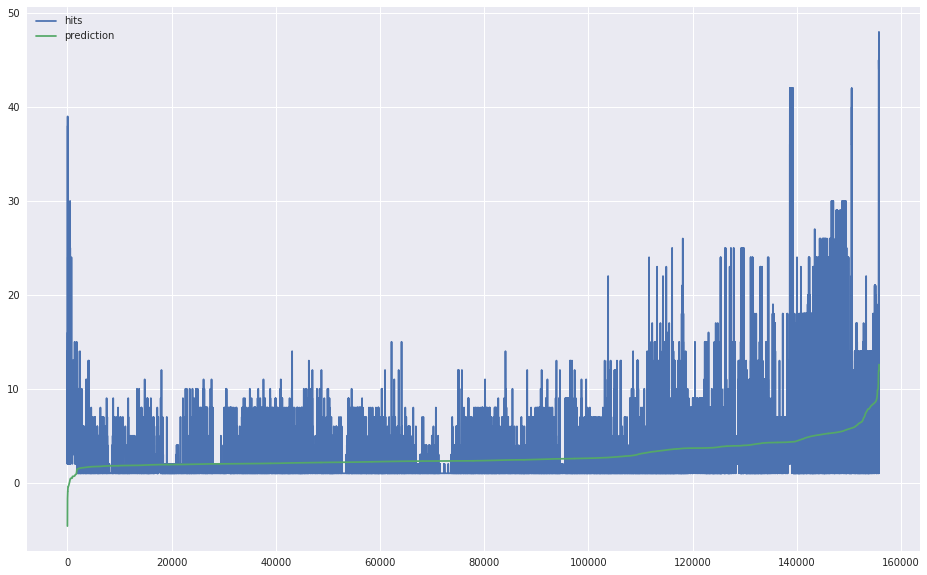

In [226]:
df_pd.plot(figsize=(16,10))

## Create csv for simulation with predictions

In [ ]:
assembler = VectorAssembler(
    inputCols=["traceTimeentryUnix", "transferStart", "accountHash","clientStateHash","datasetHash", "datasetScopeHash",
               "eventTypeHash", "eventVersionHash","filenameHash", "hostnameHash", "protocolHash", "remoteSiteHash", 
               "scopeHash", "traceIdHash", "traceIpHash", "uuidHash", "projectHash", "run_numberHash", "stream_nameHash",
               "prod_stepHash","datatypeHash","filesize_double"],
    outputCol="features")

#linearRegression will look for a column called features
output_sim = assembler.transform(df_ps_final)

In [ ]:
output_sim

In [ ]:
def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

devectorized = predicted.withColumn("xs", to_array(col("features"))).select(["features"] + [col("xs")[i] for i in range(3)])
devectorized.limit(10).toPandas()

In [ ]:
#firstelement=udf(lambda v:float(v[0]),FloatType())
#predicted.select(firstelement('features')).limit(5).toPandas()
#"traceTimeentryUnixScaled","accountHashScaled","clientStateHashScaled","datasetHashScaled","eventVersionHashScaled","filenameHashScaled","remoteSiteHashScaled","projectHashScaled","stream_nameHashScaled","prod_stepHashScaled","datatypeHashScaled","filesize_doubleScaled","run_number_doubleScaled"
#df_pd[[]] = pd.DataFrame(df_pd.features.values.tolist(), index= df_pd.index)
i = 0
df_pd['traceTimeentryUnixScaled'] = np.nan
df_pd['accountHashScaled'] = np.nan
df_pd['clientStateHashScaled'] = np.nan
df_pd['datasetHashScaled'] = np.nan
df_pd['eventVersionHashScaled'] = np.nan
df_pd['filenameHashScaled'] = np.nan
df_pd['remoteSiteHashScaled'] = np.nan
df_pd['projectHashScaled'] = np.nan
df_pd['stream_nameHashScaled'] = np.nan
df_pd['prod_stepHashScaled'] = np.nan
df_pd['datatypeHashScaled'] = np.nan
df_pd['filesize_doubleScaled'] = np.nan
df_pd['run_number_doubleScaled'] = np.nan

for index, row in df_pd.iterrows():
    df_pd.set_value(i, 'traceTimeentryUnixScaled', df_pd.features.values[i][0])
    df_pd.set_value(i, 'accountHashScaled', df_pd.features.values[i][1])
    df_pd.set_value(i, 'clientStateHashScaled', df_pd.features.values[i][2])
    df_pd.set_value(i, 'datasetHashScaled', df_pd.features.values[i][3])
    df_pd.set_value(i, 'eventVersionHashScaled', df_pd.features.values[i][4])
    df_pd.set_value(i, 'filenameHashScaled', df_pd.features.values[i][5])
    df_pd.set_value(i, 'remoteSiteHashScaled', df_pd.features.values[i][6])
    df_pd.set_value(i, 'projectHashScaled', df_pd.features.values[i][7])
    df_pd.set_value(i, 'stream_nameHashScaled', df_pd.features.values[i][8])
    df_pd.set_value(i, 'prod_stepHashScaled', df_pd.features.values[i][9])
    df_pd.set_value(i, 'datatypeHashScaled', df_pd.features.values[i][10])
    df_pd.set_value(i, 'filesize_doubleScaled', df_pd.features.values[i][11])
    df_pd.set_value(i, 'run_number_doubleScaled', df_pd.features.values[i][12])
    i+=1

In [ ]:
df_pd['features'][0]

In [ ]:
df_pd

In [ ]:
sns.regplot(x="traceTimeentryUnixScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="accountHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="clientStateHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="datasetHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="eventVersionHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="filenameHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="remoteSiteHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="projectHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="stream_nameHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="prod_stepHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="datatypeHashScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="filesize_doubleScaled", y="hits", data=df_pd);

In [ ]:
sns.regplot(x="run_number_doubleScaled", y="hits", data=df_pd);